# Registration of video frames using optimal transport (pixel space)

## Description

### Problem and general approach

The practical problem we are ultimately trying to solve here is learning to 'straighten' videos of freely-behaving *C. elegans* specimens -- more precisely, to map the different frames of a given video into a canonical space where the spatial footprints of the worm's neurons remain static across frames. One way to accomplish this is to learn a spatial transformation between each pair of successive frames that captures the worm's motion, and compose these transformations in order to map all frames to a shared space.

Image registration -- the problem of learning the spatial transformation between two images -- has been studied extensively in the computer vision literature. In its most general case, it can be stated as follows. Given two images $A$ and $B$ that are related by a spatial transform $T$ with a known parameteric form and set of parameters $\theta$, we want to estimate $\theta$. Without any other assumptions, this case of the problem is extremely difficult to solve. However, for our purposes working with microscopy images, there are a number of additional assumptions we can make. One is that all of the images we work with consist of small regions of high pixel intensity on top of a black background. This means we can expect all regions of high pixel intensity to be affected by $T$. Another is that, because $A$ and $B$ are successive frames in a microscopy video with a reasonably high sample rate, the displacement of objects between $A$ and $B$ should be small, and the correspondence between objects in $A$ and $B$ should be unambiguous.

Given these assumptions, we believe we can use an optimal transport (OT) plan to approximate the motion of the objects between images $A$ and $B$. By assuming a parametric form for the transport plan we expect to result from a particular transform $T$ (in terms of its parameters $\theta$), we can find the value of $\theta$ that minimizes the difference between this transport plan and the true optimal transport plan. 

### Derivation

#### Notation

- $A, B$: Images related by $T_{\theta}$
- $T_{\theta}$: Spatial transform with list of parameters $\theta$, that maps $A$ to $B$
- $n$: Number of pixels in images $A$ and $B$
- $d$: Dimensionality of images $A$ and $B$
- $X$ ($n \times d$): Set of pixel locations in $d$-dimensional space, where $X_i$ be the $i^{th}$ pixel location
- $a$, $b$ ($n \times 1$): Pixel intensities for the images $A$ and $B$ (e.g. $a_i$ is the intensity at location $X_i$ in image $A$)
- $P$ ($n \times n$): Optimal transport matrix for $a$ and $b$
- $\hat{P}_{ij}(\theta)$ ($n \times n$): Parametric form of transportation plan corresponding to $T_{\theta}$

#### Parametric form for transportation plan 

We assume the following parametric form for the transportation plan corresponding to $T_{\theta}$:

$
\begin{equation*}
\hat{P}_{ij}(\theta) = a_i \cdot \exp \big( \frac{-||T_{\theta}(X_i) - X_j||_2^2}{2\sigma^2} \big)
\end{equation*}
$

This form assumes that the transportation plan for a particular $T_{\theta}$ should transport all the mass $a_i$ from a particular pixel in $A$ to a Gaussian point spread function centered at $T_{\theta}(X_i)$, with a spread parameter $\sigma$. It's important to note that, for all values of $\theta$, $\hat{P}(\theta)$ represents a valid joint probability distribution over $(i, j)$, and its first marginal distribution is $a$.

#### Loss function

To estimate $\theta$, we first compute the optimal transportation plan $P$ between the distributions $a$ and $b$, using a cost matrix consisting of squared euclidean distances between the pixel locations in $X$. Then, we minimize the KL divergence between $P$ and $\hat{P}(\theta)$:

$
\begin{equation*}
\theta^* = \underset{\theta}{\mathrm{argmin\ }} D_{KL}(P || \hat{P}(\theta))
\end{equation*}
$

This KL divergence can be computed using the parametric form we chose for $\hat{P}(\theta)$:

$
\begin{align*}
D_{KL}(P || \hat{P}(\theta)) 
    &= \sum_{i, j} P_{ij} \log \frac{P_{ij}}{\hat{P}_{ij}(\theta)} \\
    &= \sum_{i, j} P_{ij} \log P_{ij} - \sum_{i, j} P_{ij} \log \hat{P}_{ij}(\theta) \\
    &= \sum_{i, j} P_{ij} \log P_{ij} - \sum_{i, j} P_{ij} \log \big[ a_i \cdot \exp \big( \frac{-||T_{\theta}(X_i) - X_j||_2^2}{2\sigma^2} \big) \big] \\
    &= \sum_{i, j} P_{ij} \log P_{ij} - \sum_{i, j} P_{ij} \log a_i  + \sum_{i, j} P_{ij} \frac{||T_{\theta}(X_i) - X_j||_2^2}{2\sigma^2} \\
\end{align*} 
$

Minimizing this with respect to $\theta$, we can ignore the first two terms:

$
\begin{align*}
\theta^*
    &= \underset{\theta}{\mathrm{argmin\ }} D_{KL}(P || \hat{P}(\theta)) \\
    &= \underset{\theta}{\mathrm{argmin\ }} \sum_{i, j} P_{ij} \log P_{ij} - \sum_{i, j} P_{ij} \log a_i  + \sum_{i, j} P_{ij} \frac{||T_{\theta}(X_i) - X_j||_2^2}{2\sigma^2} \\
    &= \underset{\theta}{\mathrm{argmin\ }} \sum_{i, j} P_{ij} \frac{||T_{\theta}(X_i) - X_j||_2^2}{2\sigma^2} \\
    &= \underset{\theta}{\mathrm{argmin\ }} \sum_{i, j} P_{ij} \cdot ||T_{\theta}(X_i) - X_j||_2^2 \\
\end{align*}
$

This minimization problem is equivalent to performing a weighted, least-squares regression where the data set consists of all pairs of pixel locations $(X_i, X_j)$, each weighted by their corresponding value $P_{ij}$ in the optimal transport plan.

## Synthetic example

### Parametric form for $T$ and loss function

For this example, we will make $T$ an affine transform, where $T_{\theta}(x) = \alpha + \beta x$, with $\theta = \{\alpha, \beta\}$. The loss function then becomes:

$
\begin{equation*}
\alpha^*, \beta^* = \underset{\alpha, \beta}{\mathrm{argmin\ }} \sum_{i, j} P_{ij} \cdot ||\beta X_i + \alpha - X_j||_2^2
\end{equation*}
$

As noted above, this is equivalent to a weighted, least-squares regression problem, in this case a linear regression, with a dataset containing all pairs of pixel locations. For high-resolution images, this set of points might be prohibitively large, but we can take advantange of the sparsity of $P$ to approximate this sum by only summing over pixel pairs $(i,j)$ where the weight $P_{ij}$ is greater than some chosen threshold.

### Implementation

In the code below, we create two images related by an affine transformation, and try to use our OT-registration method to recover this transformation and reconstruct image $B$ from image $A$.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from scipy.ndimage import affine_transform
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from skimage.transform import downscale_local_mean

from otimage import io 
from otimage.utils import plot_maxproj, pixel_dist_3d

#### Parameters

In [3]:
# Random seed 
np.random.seed(1993)

# Image size
img_shape = (50, 25, 5)
n_pixels = img_shape[0] * img_shape[1] * img_shape[2]

# Grid for evaluating densities on
xg, yg, zg = np.mgrid[0:img_shape[0], 0:img_shape[1], 0:img_shape[2]]
grid = np.stack((xg, yg, zg), axis=-1)

#### Create image $A$: Sum of three truncated Gaussians

In [4]:
# 'Cells' are truncated Gaussians
th = 1e-4
cov = 3 * np.eye(3)
mu_1 = np.array([20, 10, 3])
mu_2 = np.array([10, 15, 3])
mu_3 = np.array([10, 5, 3])
mu_4 = np.array([30, 12, 3])
cell_1 = multivariate_normal.pdf(grid, mu_1, cov).reshape(img_shape)
cell_2 = multivariate_normal.pdf(grid, mu_2, cov).reshape(img_shape)
cell_3 = multivariate_normal.pdf(grid, mu_3, cov).reshape(img_shape)
cell_4 = multivariate_normal.pdf(grid, mu_4, cov).reshape(img_shape)
cell_1[cell_1 < th] = 0 
cell_2[cell_2 < th] = 0 
cell_3[cell_3 < th] = 0 
cell_4[cell_4 < th] = 0 

# First image contains four 'cells'
A = cell_1  + cell_2 + cell_3 + cell_4

#### Choose ground-truth $\alpha$ and $\beta$ and use them to create image $B$

In [5]:
# Affine transformation to apply to source image
#theta = np.pi / 16
#beta = np.array([
#    [np.cos(theta), -np.sin(theta), 0], 
#    [np.sin(theta),  np.cos(theta), 0],
#    [0,              0,             1]
#])
beta = np.eye(3, 3)
alpha = np.array([12, 5, 0])

# Create B by applying T to A (requires inverse of T)
inv_beta = np.linalg.inv(beta)
inv_alpha = -inv_beta @ alpha
B = affine_transform(A, inv_beta, inv_alpha)

#### Add floor value and noise, normalize images

image shape: (50, 25, 5)
num. pixels: 6250
alpha:
[12  5  0]
beta:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


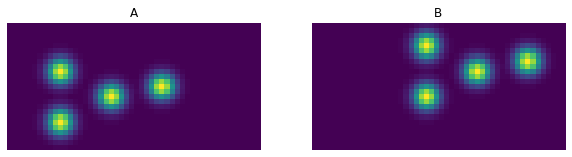

In [6]:
# Parameters
floor_val = 1e-7
noise_level = 0

# Noise is absolute value of Gaussian
noise_1 = np.abs(np.random.randn(*img_shape)) * noise_level
noise_2 = np.abs(np.random.randn(*img_shape)) * noise_level

# Add floor value and noise
A = A + floor_val + noise_1
B = B + floor_val + noise_2

# Normalize images
A = A / np.sum(A)
B = B / np.sum(B)

plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(A)
plt.title('A')
plt.axis('off');

plt.subplot(122)
plot_maxproj(B)
plt.title('B')
plt.axis('off');

print(f'image shape: {img_shape}')
print(f'num. pixels: {n_pixels}')
print('alpha:')
print(alpha)
print('beta:')
print(beta)

#### Compute optimal transport plan between frames

**Note:** Right now, we're using the balanced OT approach (`ot.sinkhorn()`) to compute the optimal transport plan between images. While this holds for the synthetic example (i.e. mass is conserved), it might not hold for true data. Need to figure out how to get unbalanced OT approach (`ot.unbalanced.sinkhorn_unbalanced()`) to work here, too.

In [7]:
# Entropic regularization parameter
reg = 1e-3

# Normalized pixel distance matrix 
M_nn = pixel_dist_3d(*img_shape)
M = M_nn / np.median(M_nn)

# Compute transport plan
P = ot.sinkhorn(A.flatten(), B.flatten(), M, reg, verbose=False)

#### Minimize cost function to estimate $\alpha$ and $\beta$

In [8]:
# Threshold to apply to P matrix (this speeds up computation)
p_th = 1e-7

# Pixel locations
X = grid.reshape(-1, 3)

# Get pairs of points with values above threshold, and corresponding weights from P matrix
a_idx, b_idx = np.nonzero(P > p_th)
pts_a = X[a_idx]
pts_b = X[b_idx]
weights = P[a_idx, b_idx]

# Use sklearn.linear_model.LinearRegression to minimize cost function
model = LinearRegression(fit_intercept=True)
model.fit(pts_a, pts_b, sample_weight=weights)

# Estimates of transform parameters
alpha_est = model.intercept_
beta_est = model.coef_

print('alpha (est):')
print(alpha_est)
print('alpha (true):')
print(alpha)

print('beta (est):')
print(beta_est)
print('beta (true):')
print(beta)

alpha (est):
[11.65026232  6.74473707  0.07942258]
alpha (true):
[12  5  0]
beta (est):
[[ 9.80321279e-01  5.72957443e-02 -1.75126267e-04]
 [ 7.95065819e-03  8.15627228e-01 -2.08126189e-03]
 [ 3.74616220e-05 -1.66937704e-04  9.68759080e-01]]
beta (true):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


#### Use estimated transform $T_{\alpha^*, \beta^*}$ to reconstruct $B$ from $A$

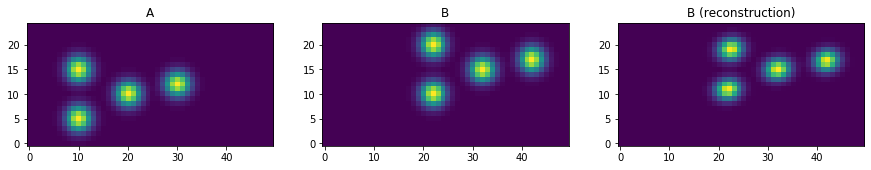

In [9]:
# Reconstruct A from B
inv_beta_est = np.linalg.inv(beta_est)
inv_alpha_est = -inv_beta_est @ alpha_est
B_recon = affine_transform(A, inv_beta_est, inv_alpha_est)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(A)
plt.title('A')
        
plt.subplot(132)
plot_maxproj(B)
plt.title('B')
        
plt.subplot(133)
plot_maxproj(B_recon)
plt.title('B (reconstruction)');

## Test on real data

This currently doesn't work, and we're not exactly sure why. The best explanation we currently have is that background pixels are preventing the model from learning the correct spatial transformation, but even this is somewhat hand-wavy.

img. shape: (890, 650, 33)
num. pixels: 19090500


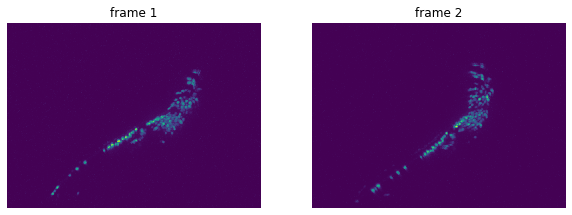

In [14]:
zimmer_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'

with io.ZimmerReader(zimmer_path) as reader:
    frame_1 = reader.get_frame(10)
    frame_2 = reader.get_frame(11)
    
img_shape = frame_1.shape
n_pixels = img_shape[0] * img_shape[1] * img_shape[2]
    
plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(frame_1)
plt.title('frame 1')
plt.axis('off');

plt.subplot(122)
plot_maxproj(frame_2)
plt.title('frame 2')
plt.axis('off');

print(f'img. shape: {img_shape}')
print(f'num. pixels: {n_pixels}')

img. shape (downsampled): (89, 65, 3)
num. pixels (downsampled): 17355


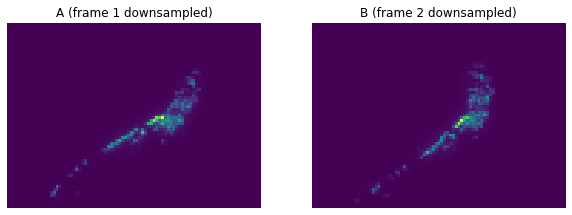

In [15]:
scl = (10, 10, 11)

# Downsample original images
A = downscale_local_mean(frame_1, scl)
B = downscale_local_mean(frame_2, scl)

img_shape_ds = A.shape
n_pixels_ds = img_shape_ds[0] * img_shape_ds[1] * img_shape_ds[2]

# Normalize images
A = A / np.sum(A)
B = B / np.sum(B)

plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(A)
plt.title('A (frame 1 downsampled)')
plt.axis('off')

plt.subplot(122)
plot_maxproj(B)
plt.title('B (frame 2 downsampled)')
plt.axis('off')

print(f'img. shape (downsampled): {img_shape_ds}')
print(f'num. pixels (downsampled): {n_pixels_ds}')

In [16]:
# Entropic regularization parameter
reg = 1e-3

# Normalized pixel distance matrix 
M_nn = pixel_dist_3d(*img_shape_ds)
M = M_nn / np.median(M_nn)

# Compute transport plan
P = ot.sinkhorn(A.flatten(), B.flatten(), M, reg, verbose=False)

In [17]:
# Threshold to apply to P matrix (this speeds up computation)
p_th = 1e-5

# Pixel locations
xg, yg, zg = np.mgrid[0:img_shape_ds[0], 0:img_shape_ds[1], 0:img_shape_ds[2]]
grid = np.stack((xg, yg, zg), axis=-1)
X = grid.reshape(-1, 3)

# Get pairs of points with values above threshold, and corresponding weights from P matrix
a_idx, b_idx = np.nonzero(P > p_th)
pts_a = X[a_idx]
pts_b = X[b_idx]
weights = P[a_idx, b_idx]

# Use sklearn.linear_model.LinearRegression to minimize cost function
model = LinearRegression(fit_intercept=True)
model.fit(pts_a, pts_b, sample_weight=weights)

# Estimates of transform parameters
alpha_est = model.intercept_
beta_est = model.coef_

print('alpha (est):')
print(alpha_est)

print('beta (est):')
print(beta_est)

alpha (est):
[0.00962852 0.60978686 0.05399955]
beta (est):
[[ 9.99990858e-01 -4.46600664e-04  2.92037038e-03]
 [ 2.57053379e-03  9.78256223e-01 -2.44345630e-02]
 [-2.57404110e-05 -1.88603191e-04  9.58397952e-01]]


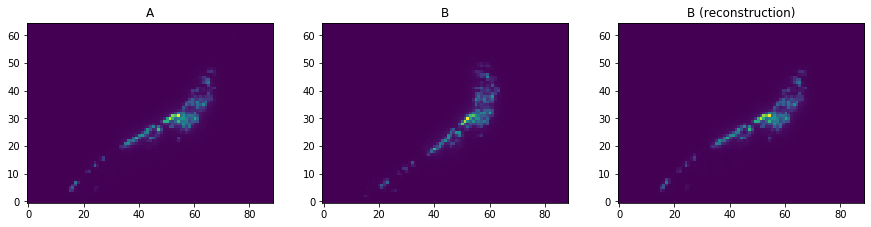

In [18]:
# Reconstruct A from B
inv_beta_est = np.linalg.inv(beta_est)
inv_alpha_est = -inv_beta_est @ alpha_est
B_recon = affine_transform(A, inv_beta_est, inv_alpha_est, mode='nearest')

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(A)
plt.title('A')
        
plt.subplot(132)
plot_maxproj(B)
plt.title('B')
        
plt.subplot(133)
plot_maxproj(B_recon)
plt.title('B (reconstruction)');